In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import pickle
from collections import Counter

!pip3 install gensim
from gensim.models.phrases import Phrases, Phraser
bigram = Phraser.load("/content/drive/My Drive/DevC/saves/bigram.pkl")

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
w2vdict = KeyedVectors.load("/content/drive/My Drive/DevC/saves/w2v.wordvectors")
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from sklearn.metrics import f1_score, classification_report

In [ ]:
ev_path = "/content/drive/My Drive/DevC/process materials/Englishwords.xlsx"
sf_path = "/content/drive/My Drive/DevC/process materials/Shortform.xlsx"

englishwords = pd.read_excel(ev_path, index_col = "English")
shortform = pd.read_excel(sf_path, index_col= "Short")

In [ ]:
# read data from text files
data = pd.read_csv("/content/drive/My Drive/DevC/datasets/tiki.csv")
#print(data.head(5))
data = data[["content", "label"]]
data = data[data["label"].notnull()]

In [ ]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def preprocess(text):
  #bỏ tag html và emoji
  text = re.sub('<[^>]*>', '', text)
  text = deEmojify(text)

  #thay chữ cái viết hoa thành viết thường
  text = text.lower()

  #xóa dấu ngắt câu, xóa link và các chữ có chứa chữ số
  clean_text = []
  punc_list = '.,;:?!\|/&@`~()-_@#$%^*'
  for w in (text.split()):
    if "http" in w:
      continue
    clean_text.append(w)
  text = ' '.join(clean_text)
  for punc in punc_list:
    text = text.replace(punc, ' ')

  #xóa bỏ các chữ cái lặp liên tiếp nhau (đỉnhhhhhhhhhh, vipppppppppppppppp)
  length = len(text)
  char = 0
  while char <length-1:
    if text[char] == text[char+1]:
      text = text[:char]+text[char+1:]
      #print(text)
      length-=1
      continue
    char+=1  
  numbers = ["không", "một", "hai", "ba", "bốn", "năm", "sáu", "bảy", "tám", "chín"]
  #chuyển đổi các từ tiếng anh và viết tắt thông dụng sang tiếng Việt chuẩn:
  text_split = text.split()
  for i, w in enumerate(text_split):
    if w in englishwords.index:
      text_split[i] = str(englishwords.loc[w, "Vietnamese"])
    if w in shortform.index:
      text_split[i] = str(shortform.loc[w, "Long"])
    if w.isdigit():
      text_split[i] = ' '.join([numbers[int(c)] for c in w]) 
  text = ' '.join(text_split)

  #loại bỏ tất cả các kí tự đặc biệt còn lại
  digits_and_characters = 'aăâbcdđeêfghijklmnoôơpqrstuưvxywzáàảãạắằẳẵặấầẩẫậéèẻẽẹếềểễệíìỉĩịóòỏõọốồổỗộớờởỡợúùủũụứừửữựýỳỷỹỵ0123456789 '
  text = ''.join([i for i in text if i in digits_and_characters])
  return text

In [ ]:
#split all sentences in corpus
def splitCorpus(corpus):
  t = [sentence.split() for sentence in corpus]
  return t

In [ ]:
#join all splited sentences to a big text document
def joinAllSplit(tokenized_sentences):
  sentences = [' '.join(sentence) for sentence in tokenized_sentences]
  return ' '.join(sentences)

In [ ]:
#create initial matrix for embedding layer
def createInitialEmbedWeights(vocab, w2vdict):
  matrix = np.zeros((len(vocab)+1, w2vdict.vector_size ))
  for i, w in enumerate(vocab):
    if w in w2vdict.vocab.keys():
      matrix[i+1, :] = w2vdict[w]
  return matrix
    

In [ ]:
#convert words to numbers and remove unknown words
def sentenceToInt(sentences):
  #print(sentences)
  new_sentences = []
  for sentence in sentences:
    new_sentence = [word2idx[word] for word in sentence if word in word2idx.keys()]
    new_sentences.append(new_sentence)
  return new_sentences

In [ ]:
#pad int_sentences to the feature_leng
def padFeature(sentences, feature_leng = 50):
  smatrix = np.zeros((len(sentences), feature_leng))
  for sen_index, sentence in enumerate(sentences):
    padding = max(0, feature_leng - len(sentence))
    for word_index in range(feature_leng):
      if word_index < padding:
        smatrix[sen_index, word_index] = 0
      else:
        smatrix[sen_index, word_index] = sentence[word_index-padding]
  return smatrix

In [ ]:
for record in data.index:
  data.loc[record,"content"] = preprocess(data.loc[record, "content"])

In [ ]:
data = data.sample(frac = 1).reset_index(drop = True)

In [ ]:
split = 0.8
num_record = data.shape[0]
data_train = data.loc[:num_record*split]
data_val = data.loc[num_record*split:num_record*(0.5+split/2)]
data_test = data.loc[num_record*(0.5 + split/2):]

In [ ]:
data_train["label"].value_counts()

 1.0    4411
 0.0    2323
-1.0    1607
Name: label, dtype: int64

In [ ]:
sub_data1 = data_train[data_train["label"] == 1.]
sub_data2 = data_train[data_train["label"] == 0.]
sub_data3 = data_train[data_train["label"] == -1.]
fixed_data_train = pd.concat([sub_data1, sub_data2, sub_data2, sub_data3, sub_data3, sub_data3]).sample(frac = 1)
print(fixed_data_train["label"].value_counts())

-1.0    4821
 0.0    4646
 1.0    4411
Name: label, dtype: int64


In [ ]:
comments_train = fixed_data_train.loc[:,"content"].tolist()                           
labels_train = fixed_data_train.loc[:,"label"].astype(int).tolist()
comments_val = data_val.loc[:,"content"].tolist()
labels_val = data_val.loc[:, "label"].astype(int).tolist()
comments_test = data_test.loc[:, "content"].tolist()
labels_test = data_test.loc[:, "label"].astype(int).tolist()
#labels_series.fillna(0, inplace = True)


In [ ]:
comments_train = splitCorpus(comments_train)
comments_val = splitCorpus(comments_val)
comments_test = splitCorpus(comments_test)

In [ ]:
sentences_train = list(bigram[comments_train])
sentences_val = list(bigram[comments_val])
sentences_test = list(bigram[comments_test])

In [ ]:
all_text = joinAllSplit(sentences_train)

In [ ]:
counter = Counter(all_text.split())
vocab = [w for w in counter.keys() if counter[w]>5]

In [ ]:
vocab = set(vocab + list(w2vdict.vocab.keys()))
word2idx = {w:i+1 for i,w in enumerate(vocab)}
idx2word = {i+1: w for i, w in enumerate(vocab)}

In [ ]:
matrix = createInitialEmbedWeights(vocab, w2vdict)

In [ ]:
for i,s in enumerate(sentences_train):
  new_s = [w for w in s if w in vocab]
  sentences_train[i] = new_s
for i,s in enumerate(sentences_val):
  new_s = [w for w in s if w in vocab]
  sentences_val[i] = new_s

count    13878.000000
mean        12.325335
std         11.194823
min          0.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        138.000000
dtype: float64

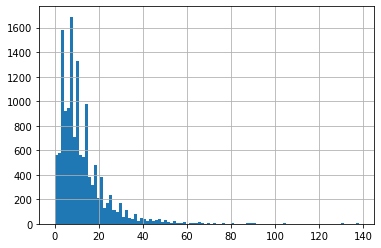

In [ ]:
train_length = []
val_length = []
test_length = []
for i in sentences_train:
  train_length.append(len(i))
for i in sentences_val:
  val_length.append(len(i))
for i in sentences_test:
  test_length.append(len(i))
X = pd.Series(train_length)
X.hist(bins = 100)
X.describe()

count    1043.000000
mean       11.614573
std        10.021621
min         0.000000
25%         5.000000
50%         9.000000
75%        15.000000
max        85.000000
dtype: float64

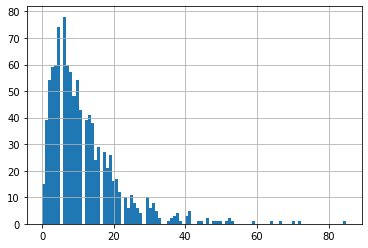

In [ ]:
X = pd.Series(val_length)
X.hist(bins = 100)
X.describe()

In [ ]:
sentences_train = [sentences_train[i] for i,l in enumerate(train_length) if l>0]
labels_train = [labels_train[i] for i, l in enumerate(train_length) if l >0]
sentences_val = [sentences_val[i] for i,l in enumerate(val_length) if l> 0]
labels_val = [labels_val[i] for i, l in enumerate(val_length) if l >0]
sentences_test = [sentences_test[i] for i,l in enumerate(test_length) if l> 0]
labels_test = [labels_test[i] for i, l in enumerate(test_length) if l >0]

In [ ]:
print(len(sentences_train))

13697


In [ ]:
sentences_int_train = sentenceToInt(sentences_train)
sentences_int_val = sentenceToInt(sentences_val)
sentences_int_test = sentenceToInt(sentences_test)

In [ ]:
n_cell = 50
train_to_int = padFeature(sentences = sentences_int_train, feature_leng = n_cell)
val_to_int = padFeature(sentences = sentences_int_val, feature_leng= n_cell)
test_to_int = padFeature(sentences = sentences_int_test, feature_leng = n_cell)

In [ ]:
train_x = train_to_int
train_y = np.array(labels_train)
valid_x = val_to_int
valid_y = np.array(labels_val)
test_x = test_to_int
test_y = np.array(labels_test)

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
val_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
#convert emb matrix to tensor:
emb_matrix = torch.from_numpy(matrix)
#print(emb_matrix)
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last= True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle= True, batch_size= batch_size, drop_last = True)

In [ ]:
#model with 3 part: embedding layer -> stack lstms -> fc layers with softmax classifier
class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, n_cell, drop_prob = 0.2):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(emb_matrix, freeze = False)
        self.lstm = nn.LSTM(input_size = embedding_dim,hidden_size = hidden_dim, num_layers = n_layers, batch_first = True, dropout = drop_prob, bidirectional = False)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax(dim = 1)        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        embeds = self.embedding(x)
        embeds = embeds.float()
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = out.contiguous().view(batch_size, -1, output_size)
        out = out[:, -1, :]
        out = self.softmax(out)
        return out, hidden
    
    
    def init_hidden(self, batch_size, train_on_gpu = False):
        ''' Initializes hidden state '''
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().float().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().float().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().float(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().float())
        
        return hidden

In [ ]:
# Instantiate the model w/ hyperparams
output_size = 3
embedding_dim = 200
hidden_dim = 128
n_layers = 2
drop_prob = 0.2
net = SentimentLSTM(output_size, embedding_dim, hidden_dim, n_layers, n_cell, drop_prob)
print(net)

SentimentLSTM(
  (embedding): Embedding(12345, 200)
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
# loss and optimization functions
lr=0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)


# training params

epochs = 20
counter = 0
print_every = 60
clip=5 # gradient clipping

# move model to GPU, if available
# train for some number of epochs
for e in range(epochs):
    
    # initialize hidden state

    # batch loop
    for inputs, labels in train_loader:
        counter += 1
        #print(inputs.shape)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()
        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        
        output_prob,h = net(inputs, h)

        # calculate the loss and perform backprop
        labels = labels+1
        #print(labels)
        loss = criterion(output_prob, labels)
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in val_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                labels = labels+1
                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/8... Step: 60... Loss: 0.873528... Val Loss: 0.945328
Epoch: 1/8... Step: 120... Loss: 0.942088... Val Loss: 0.883930
Epoch: 1/8... Step: 180... Loss: 0.775925... Val Loss: 0.888412
Epoch: 1/8... Step: 240... Loss: 0.799198... Val Loss: 0.925418
Epoch: 2/8... Step: 300... Loss: 0.912166... Val Loss: 0.899708
Epoch: 2/8... Step: 360... Loss: 0.856439... Val Loss: 0.882499
Epoch: 2/8... Step: 420... Loss: 0.888348... Val Loss: 0.884476
Epoch: 2/8... Step: 480... Loss: 0.814862... Val Loss: 0.863519
Epoch: 2/8... Step: 540... Loss: 0.717352... Val Loss: 0.846933
Epoch: 3/8... Step: 600... Loss: 0.737438... Val Loss: 0.851578
Epoch: 3/8... Step: 660... Loss: 0.684977... Val Loss: 0.876441
Epoch: 3/8... Step: 720... Loss: 0.667595... Val Loss: 0.874892
Epoch: 3/8... Step: 780... Loss: 0.820865... Val Loss: 0.857155
Epoch: 4/8... Step: 840... Loss: 0.722614... Val Loss: 0.850648
Epoch: 4/8... Step: 900... Loss: 0.699642... Val Loss: 0.843857
Epoch: 4/8... Step: 960... Loss: 0.722341

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net(inputs, h)
    
    # calculate loss
    labels = labels+1
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.argmax(output, dim = 1)  # rounds to the nearest integer
    #print("f1 batch score ", classification_report(labels, pred))
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.816
Test accuracy: 0.712
